In [0]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
cd /gdrive/My\ Drive/

/gdrive/My Drive


In [0]:
import pandas as pd
import numpy as np
import pylab as plt
import pandas as pd
from glob import glob
from astropy.io import fits
from astropy.table import Table
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, MaxPooling1D, Flatten , BatchNormalization , ReLU
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras as K

Using TensorFlow backend.


In [0]:
def conf_plotter(y_true, y_pred, classes,
                      normalize=0,
                      title=None,
                      cmap=plt.cm.pink_r,
                      mode = 'train',
                      save = 0,
                      name = 'conf.jpg'):

    if not title:
        if mode == 'train':
            title = 'Normalized confusion matrix on train dataset'
        else:
            title = 'Normalized confusion matrix on test dataset'
            

    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax ,fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           xlabel='Predicted label',
           ylabel='True label')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] ):
                    
        item.set_fontsize(20)
     
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        
        item.set_fontsize(12)

        
                
    plt.gca().invert_yaxis()
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    if save == 1:
        plt.savefig(name)
    return ax

In [0]:
data = pd.read_csv('./data/Features_train4.csv')

In [0]:
df = pd.DataFrame(data)
df.head()

,Unnamed: 0,target,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""",...,__freq_signif_ratio_21___2_,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,0,92,0.998599,0.000580,0.253477,0.582881,0.001400,0.398073,0.005095,1.692928e-06,0.000022,0.000540,0.000002,0.231565,0.945714,0.269740,0.102732,0.419864,0.457157,0.279084,0.000486,0.522296,0.539588,0.000092,3.515728e-04,0.023115,0.486666,0.035217,0.006315,0.048923,0.520752,0.002080,0.001155,0.016812,0.522493,0.002151,0.001181,0.011624,0.514756,0.000885,...,0.450552,0.631785,0.597880,0.626320,0.418006,0.337524,0.424850,0.434345,0.278001,0.539139,0.127557,0.268992,0.139321,0.110750,0.129510,0.401857,0.273375,0.396428,0.999929,0.496892,0.609820,0.492746,0.437672,0.959545,1.0,0.0,0.000000,0.000000,0.793282,0.481390,0.0,0.0,0.453353,0.00138,0.016690,0.020350,0.017798,0.020112,0.017101,0.015200
1,1,88,0.999543,0.000315,0.254123,0.584075,0.000014,0.409715,0.000537,2.344565e-08,0.000002,0.000063,0.000001,0.232165,0.166694,0.000530,0.234246,0.423389,0.402260,0.280379,0.000002,0.522246,0.539480,0.000085,6.464922e-05,0.029284,0.494760,0.000090,0.000433,0.051468,0.487141,0.000012,0.000079,0.020477,0.498674,0.000017,0.000099,0.016752,0.484139,0.000014,...,0.439772,0.624041,0.604519,0.530395,0.464654,0.392311,0.484569,0.449170,0.554486,0.529920,0.113348,0.076164,0.086336,0.111848,0.166125,0.369672,0.228406,0.476676,0.999922,0.463559,0.552805,0.438561,0.851534,0.182289,1.0,0.0,0.527737,0.964483,0.793282,0.481390,0.0,0.0,0.453353,0.00068,0.003743,0.000729,0.000664,0.000990,0.000886,0.000806
2,2,42,0.999539,0.000328,0.254143,0.584092,0.000019,0.510730,0.000707,9.928179e-07,0.000003,0.000061,0.000002,0.244197,0.064381,0.000368,0.336435,0.423389,0.656362,0.280500,0.000013,0.522639,0.540883,0.000002,9.836503e-07,0.049192,0.500738,0.000012,0.000030,0.084877,0.524475,0.000033,0.000049,0.125095,0.656837,0.000052,0.000075,0.154875,0.672325,0.000060,...,0.528993,0.660896,0.700214,0.596515,0.539890,0.407594,0.501768,0.579188,0.617399,0.567847,0.758609,0.657327,0.204572,0.292940,0.318262,0.500862,0.221734,0.477941,0.999924,0.473776,0.567853,0.436264,0.639934,0.584175,1.0,0.5,0.067674,0.851053,0.803618,0.483366,0.0,0.0,0.747074,0.00018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,3,90,0.999542,0.000400,0.254178,0.584101,0.000089,0.568282,0.000316,2.096156e-05,0.000003,0.000017,0.000007,0.807492,0.169068,0.008658,0.543261,0.423442,0.794985,0.281012,0.000060,0.522617,0.540709,0.000058,2.658504e-05,0.104780,0.603580,0.000504,0.000631,0.888741,0.960817,0.000145,0.000202,0.637555,0.873816,0.000247,0.000331,0.309674,0.744794,0.000201,...,0.195112,0.332318,0.429168,0.2279

In [0]:
df = df.drop(columns=['Unnamed: 0'])

In [0]:
df.head()

,target,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",...,__freq_signif_ratio_21___2_,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,92,0.998599,0.000580,0.253477,0.582881,0.001400,0.398073,0.005095,1.692928e-06,0.000022,0.000540,0.000002,0.231565,0.945714,0.269740,0.102732,0.419864,0.457157,0.279084,0.000486,0.522296,0.539588,0.000092,3.515728e-04,0.023115,0.486666,0.035217,0.006315,0.048923,0.520752,0.002080,0.001155,0.016812,0.522493,0.002151,0.001181,0.011624,0.514756,0.000885,0.001043,...,0.450552,0.631785,0.597880,0.626320,0.418006,0.337524,0.424850,0.434345,0.278001,0.539139,0.127557,0.268992,0.139321,0.110750,0.129510,0.401857,0.273375,0.396428,0.999929,0.496892,0.609820,0.492746,0.437672,0.959545,1.0,0.0,0.000000,0.000000,0.793282,0.481390,0.0,0.0,0.453353,0.00138,0.016690,0.020350,0.017798,0.020112,0.017101,0.015200
1,88,0.999543,0.000315,0.254123,0.584075,0.000014,0.409715,0.000537,2.344565e-08,0.000002,0.000063,0.000001,0.232165,0.166694,0.000530,0.234246,0.423389,0.402260,0.280379,0.000002,0.522246,0.539480,0.000085,6.464922e-05,0.029284,0.494760,0.000090,0.000433,0.051468,0.487141,0.000012,0.000079,0.020477,0.498674,0.000017,0.000099,0.016752,0.484139,0.000014,0.000077,...,0.439772,0.624041,0.604519,0.530395,0.464654,0.392311,0.484569,0.449170,0.554486,0.529920,0.113348,0.076164,0.086336,0.111848,0.166125,0.369672,0.228406,0.476676,0.999922,0.463559,0.552805,0.438561,0.851534,0.182289,1.0,0.0,0.527737,0.964483,0.793282,0.481390,0.0,0.0,0.453353,0.00068,0.003743,0.000729,0.000664,0.000990,0.000886,0.000806
2,42,0.999539,0.000328,0.254143,0.584092,0.000019,0.510730,0.000707,9.928179e-07,0.000003,0.000061,0.000002,0.244197,0.064381,0.000368,0.336435,0.423389,0.656362,0.280500,0.000013,0.522639,0.540883,0.000002,9.836503e-07,0.049192,0.500738,0.000012,0.000030,0.084877,0.524475,0.000033,0.000049,0.125095,0.656837,0.000052,0.000075,0.154875,0.672325,0.000060,0.000076,...,0.528993,0.660896,0.700214,0.596515,0.539890,0.407594,0.501768,0.579188,0.617399,0.567847,0.758609,0.657327,0.204572,0.292940,0.318262,0.500862,0.221734,0.477941,0.999924,0.473776,0.567853,0.436264,0.639934,0.584175,1.0,0.5,0.067674,0.851053,0.803618,0.483366,0.0,0.0,0.747074,0.00018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,90,0.999542,0.000400,0.254178,0.584101,0.000089,0.568282,0.000316,2.096156e-05,0.000003,0.000017,0.000007,0.807492,0.169068,0.008658,0.543261,0.423442,0.794985,0.281012,0.000060,0.522617,0.540709,0.000058,2.658504e-05,0.104780,0.603580,0.000504,0.000631,0.888741,0.960817,0.000145,0.000202,0.637555,0.873816,0.000247,0.000331,0.309674,0.7

In [0]:
np.any(np.isinf(df))

False

In [0]:
targets = df['target']
classes = targets.unique()
classes

array([92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52,  6, 64, 53])

In [0]:
targets[:5]

0    92
1    88
2    42
3    90
4    90
Name: target, dtype: int64

In [0]:
class_map =[] 

for i,val in enumerate(classes):
    class_map.append([val , i])
class_map

[[92, 0],
 [88, 1],
 [42, 2],
 [90, 3],
 [65, 4],
 [16, 5],
 [67, 6],
 [95, 7],
 [62, 8],
 [15, 9],
 [52, 10],
 [6, 11],
 [64, 12],
 [53, 13]]

In [0]:
[class_map[i][0] for i in range(len(class_map))]

[92, 88, 42, 90, 65, 16, 67, 95, 62, 15, 52, 6, 64, 53]

In [0]:
len(class_map)

14

In [0]:
def one_hot(targets , class_map):
    
    vecs = []
    
    for j in targets:
        
        vec = np.zeros((classes.shape[0],))
        
        for i in range(len(class_map)):
            if class_map[i][0]== j:
                vec[class_map[i][1]] =+ 1
                vecs.append(vec)
    return vecs

In [0]:
one_hot(targets , class_map=class_map)[:5]

[array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])]

In [0]:
def remove_structure(x):
    return np.array(x)

In [0]:
# n_train = 3*df.shape[0]//4

# X_train = df_.iloc[:n_train].drop([356, 67] ,1)
# y_train = one_hot(targets , class_map=class_map)[:n_train]
# # y_train = df['vectors'][:n_train]

# X_test = df_.iloc[n_train:].drop([356, 67] ,1)
# # y_test = df['vectors'][n_train:]
# y_test = one_hot(targets , class_map=class_map)[n_train:]


# X_train = remove_structure(X_train)
# X_test = remove_structure(X_test)
# y_train = remove_structure(y_train)
# y_test = remove_structure(y_test)

# input_dim = X_train.shape[1]
# input_dim

In [0]:
df.shape

(7848, 369)

In [0]:
X = df.drop('target' ,1)
print(X.shape)
y = one_hot(targets , class_map=class_map)

y = pd.DataFrame(y)

x_col = X.columns
X = pd.DataFrame(X)
c = X.columns
col = dict(zip(c,x_col))
X = X.rename(columns = col)

# X = remove_structure(X)
# y = remove_structure(y)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
input_dim = X_train.shape[1]
input_dim

(7848, 368)


368

In [0]:
X.head()

,flux_min,flux_max,flux_mean,flux_median,flux_std,flux_skew,flux_err_min,flux_err_max,flux_err_mean,flux_err_median,flux_err_std,flux_err_skew,detected_mean,flux_ratio_sq_sum,flux_ratio_sq_skew,flux_by_flux_ratio_sq_sum,flux_by_flux_ratio_sq_skew,flux_w_mean,flux_diff1,flux_diff2,flux_diff3,"0__fft_coefficient__coeff_0__attr_""abs""","0__fft_coefficient__coeff_1__attr_""abs""",0__kurtosis,0__skewness,"1__fft_coefficient__coeff_0__attr_""abs""","1__fft_coefficient__coeff_1__attr_""abs""",1__kurtosis,1__skewness,"2__fft_coefficient__coeff_0__attr_""abs""","2__fft_coefficient__coeff_1__attr_""abs""",2__kurtosis,2__skewness,"3__fft_coefficient__coeff_0__attr_""abs""","3__fft_coefficient__coeff_1__attr_""abs""",3__kurtosis,3__skewness,"4__fft_coefficient__coeff_0__attr_""abs""","4__fft_coefficient__coeff_1__attr_""abs""",4__kurtosis,...,__freq_signif_ratio_21___2_,__freq_signif_ratio_21___3_,__freq_signif_ratio_21___4_,__freq_signif_ratio_21___5_,__freq_signif_ratio_31___0_,__freq_signif_ratio_31___1_,__freq_signif_ratio_31___2_,__freq_signif_ratio_31___3_,__freq_signif_ratio_31___4_,__freq_signif_ratio_31___5_,__freq_varrat___0_,__freq_varrat___1_,__freq_varrat___2_,__freq_varrat___3_,__freq_varrat___4_,__freq_varrat___5_,__freq_y_offset___0_,__freq_y_offset___1_,__freq_y_offset___2_,__freq_y_offset___3_,__freq_y_offset___4_,__freq_y_offset___5_,time_score,phase_score,ddf_bool,true_submodel,true_z,true_distmod,true_lensdmu,true_vpec,true_rv,true_av,true_peakmjd,libid_cadence,tflux_u,tflux_g,tflux_r,tflux_i,tflux_z,tflux_y
0,0.998599,0.000580,0.253477,0.582881,0.001400,0.398073,0.005095,1.692928e-06,0.000022,0.000540,0.000002,0.231565,0.945714,0.269740,0.102732,0.419864,0.457157,0.279084,0.000486,0.522296,0.539588,0.000092,3.515728e-04,0.023115,0.486666,0.035217,0.006315,0.048923,0.520752,0.002080,0.001155,0.016812,0.522493,0.002151,0.001181,0.011624,0.514756,0.000885,0.001043,0.006630,...,0.450552,0.631785,0.597880,0.626320,0.418006,0.337524,0.424850,0.434345,0.278001,0.539139,0.127557,0.268992,0.139321,0.110750,0.129510,0.401857,0.273375,0.396428,0.999929,0.496892,0.609820,0.492746,0.437672,0.959545,1.0,0.0,0.000000,0.000000,0.793282,0.481390,0.0,0.0,0.453353,0.00138,0.016690,0.020350,0.017798,0.020112,0.017101,0.015200
1,0.999543,0.000315,0.254123,0.584075,0.000014,0.409715,0.000537,2.344565e-08,0.000002,0.000063,0.000001,0.232165,0.166694,0.000530,0.234246,0.423389,0.402260,0.280379,0.000002,0.522246,0.539480,0.000085,6.464922e-05,0.029284,0.494760,0.000090,0.000433,0.051468,0.487141,0.000012,0.000079,0.020477,0.498674,0.000017,0.000099,0.016752,0.484139,0.000014,0.000077,0.012611,...,0.439772,0.624041,0.604519,0.530395,0.464654,0.392311,0.484569,0.449170,0.554486,0.529920,0.113348,0.076164,0.086336,0.111848,0.166125,0.369672,0.228406,0.476676,0.999922,0.463559,0.552805,0.438561,0.851534,0.182289,1.0,0.0,0.527737,0.964483,0.793282,0.481390,0.0,0.0,0.453353,0.00068,0.003743,0.000729,0.000664,0.000990,0.000886,0.000806
2,0.999539,0.000328,0.254143,0.584092,0.000019,0.510730,0.000707,9.928179e-07,0.000003,0.000061,0.000002,0.244197,0.064381,0.000368,0.336435,0.423389,0.656362,0.280500,0.000013,0.522639,0.540883,0.000002,9.836503e-07,0.049192,0.500738,0.000012,0.000030,0.084877,0.524475,0.000033,0.000049,0.125095,0.656837,0.000052,0.000075,0.154875,0.672325,0.000060,0.000076,0.134063,...,0.528993,0.660896,0.700214,0.596515,0.539890,0.407594,0.501768,0.579188,0.617399,0.567847,0.758609,0.657327,0.204572,0.292940,0.318262,0.500862,0.221734,0.477941,0.999924,0.473776,0.567853,0.436264,0.639934,0.584175,1.0,0.5,0.067674,0.851053,0.803618,0.483366,0.0,0.0,0.747074,0.00018,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.999542,0.000400,0.254178,0.584101,0.000089,0.568282,0.000316,2.096156e-05,0.000003,0.000017,0.000007,0.807492,0.169068,0.008658,0.543261,0.423442,0.794985,0.281012,0.000060,0.522617,0.540709,0.000058,2.658504e-05,0.104780,0.603580,0.000504,0.000631,0.888741,0.960817,0.000145,0.000202,0.637555,0.873816,0.000247,0

In [0]:
X_train.shape

(5886, 368)

In [0]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
3142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3438,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1101,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5671,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
X_train.to_csv('./data/X_train.csv')
y_train.to_csv('./data/y_train.csv')
X_test.to_csv('./data/X_test.csv')
y_test.to_csv('./data/y_test.csv')

In [0]:
X_train = pd.read_csv('./data/X_train.csv')
y_train = pd.read_csv('./data/y_train.csv')
X_test = pd.read_csv('./data/X_test.csv')
y_test= pd.read_csv('./data/y_test.csv')

In [0]:
y_train.shape

(5886, 15)

In [0]:
y_train = y_train.drop(columns =['Unnamed: 0'] )
y_test = y_test.drop(columns =['Unnamed: 0'] )

In [0]:
y_train.shape

(5886, 14)

In [0]:
X_train = X_train.drop(columns =['Unnamed: 0'] )
X_test = X_test.drop(columns =['Unnamed: 0'] )

X_train.shape

(5886, 368)

In [0]:
n_class = len(classes)
n_class

14

In [0]:
af = tf.keras.activations.selu

K.backend.clear_session()
model = Sequential()

model.add(Dense(input_dim, input_dim=input_dim))
model.add(BatchNormalization(trainable=True))
model.add(Activation(af))

model.add(Dense(256))
model.add(BatchNormalization(trainable=True))
model.add(Activation(af))
model.add(Dropout(rate = 0.3))

model.add(Dense(128))
model.add(BatchNormalization(trainable=True))
model.add(Activation(af))

model.add(Dense(128))
model.add(BatchNormalization(trainable=True))
model.add(Activation(af))
model.add(Dropout(rate = 0.5))

model.add(Dense(64))
model.add(BatchNormalization(trainable=True))
model.add(Activation(af))

model.add(Dense(64))
model.add(BatchNormalization(trainable=True))
model.add(Activation(af))
model.add(Dropout(rate = 0.3))

model.add(Dense(32))
model.add(BatchNormalization(trainable=True))
model.add(Activation(af))

model.add(Dense(32))
model.add(BatchNormalization(trainable=True))
model.add(Activation(af))
model.add(Dropout(rate = 0.5))

model.add(Dense(n_class, activation='softmax'))

In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 368)               135792    
_________________________________________________________________
batch_normalization_1 (Batch (None, 368)               1472      
_________________________________________________________________
activation_1 (Activation)    (None, 368)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               94464     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

In [0]:
#sgd = keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
adam = K.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-3, amsgrad=False)

In [0]:
model.compile(loss = K.losses.categorical_crossentropy , optimizer=adam)

In [0]:
model.fit(X_train,y_train,epochs=100,batch_size=200,verbose=0)

In [0]:
model.fit(X_train,y_train,epochs=100,batch_size=300,verbose=0)

In [0]:
model.fit(X_train,y_train,epochs=100,batch_size=300,verbose=0)

In [0]:
# evaluate the model
model.evaluate(X_train, y_train, verbose=1)

5886/5886 [==============================] - 1s 176us/step


0.36020391767846455

In [0]:
model.fit(X_train,y_train,epochs=100,batch_size=300,verbose=0)

In [0]:
# evaluate the model
model.evaluate(X_train, y_train, verbose=1)

5886/5886 [==============================] - 1s 124us/step


0.3134987752984626

In [0]:
model.fit(X_train,y_train,epochs=400,batch_size=1000,verbose=0)

In [0]:
path = './NN_models/4'
# serialize model to JSON
model_json = model.to_json()
with open(str(path)+'/model.json', "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights(str(path)+'/model.h5')
print("Saved model to disk")

Saved model to disk


In [0]:
from keras.models import model_from_json

# load json and create model
json_file = open('./NN_models/4/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("./NN_models/4/model.h5")
print("Loaded model from disk")

# # evaluate loaded model on test data
# loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
# score = loaded_model.evaluate(X, Y, verbose=0)
# print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk


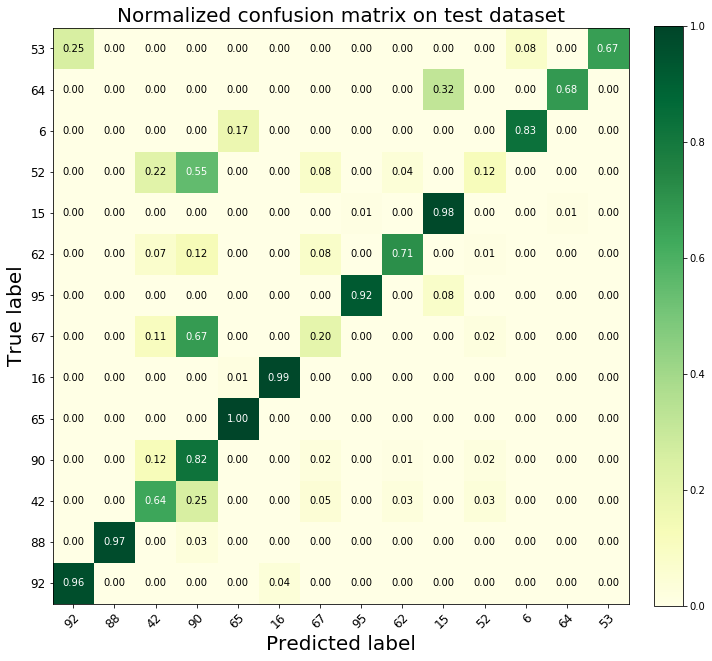

In [0]:
predicts = model.predict(X_test)

predicts = np.array(predicts)
y_test = np.array(y_test)

Y = []
pr= []

for i in range(len(y_test)):
    
    pr.append(np.argmax(predicts[i]))
    
    Y.append(np.argmax((y_test[i])))


labels = [class_map[i][0] for i in range(len(class_map))]  
    
conf_plotter(Y , pr , labels , normalize=1, mode='test' , cmap = plt.cm.YlGn, save=0 , name='test_3.jpg')

In [0]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y, pr)
np.trace(cm)/len(y_test)

0.81855249745158

In [0]:
print(predicts.shape)
print(np.array(Y).shape)
print(np.array(pr).shape)
print(y_test.shape)

(1962, 14)
(1962,)
(1962,)
(1962, 14)


In [0]:
y_test = pd.DataFrame(y_test)
predicts = pd.DataFrame(predicts)

In [0]:
def multi_weighted_logloss(y_true, y_preds):
    """
    @author olivier https://www.kaggle.com/ogrellier
    multi logloss for PLAsTiCC challenge
    """
    classes = targets.unique()
    class_weight = {6: 1, 15: 2, 16: 1, 42: 1, 52: 1, 53: 1, 62: 1, 64: 2, 65: 1, 67: 1, 88: 1, 90: 1, 92: 1, 95: 1}
    
    
    y_p = y_preds
    
    y_ohe = pd.get_dummies(y_true)
    # Normalize rows and limit y_preds to 1e-15, 1-1e-15
    y_p = np.clip(a=y_p, a_min=1e-15, a_max=1-1e-15)
    # Transform to log
    y_p_log = np.log(y_p)

    
    y_log_ones = np.sum(y_ohe.values * y_p_log, axis=0)
    # Get the number of positives for each class
    nb_pos = y_ohe.sum(axis=0).values.astype(float)
    # Weight average and divide by the number of positives
    class_arr = np.array([class_weight[k] for k in sorted(class_weight.keys())])
    y_w = y_log_ones * class_arr / nb_pos
    
    loss = - np.sum(y_w) / np.sum(class_arr)
    return loss

multi_weighted_logloss(y_test, predicts)

1.3111265887667425

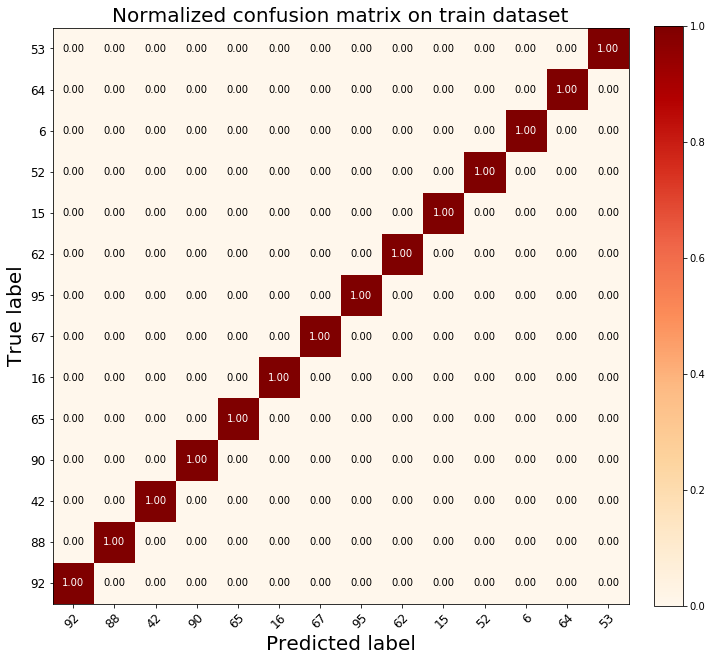

In [0]:
predicts = model.predict(X_train)

Y = []
pr= []

for i in range(len(y_train)):
    
    pr.append(np.argmax((np.array(predicts)[i])))
    Y.append(np.argmax(np.array(y_train)[i]))


labels = [class_map[i][0] for i in range(len(class_map))]   
    
conf_plotter(Y , pr , labels , normalize=1, cmap = plt.cm.OrRd, save=1 , name='train_3.jpg')